<h1>Project 4: SafeComm Digital Security Solutions</h1>
<p>Team Captain: E00020</p>
<p>Member 2: E00491</p>
<p>Member 3: E00045</p>
</br></br>
<h2>Table of Contents</h2>
<ol>
  <li><a href="#section1">Importing Libaries</a></li>
  <li><a href="#section2">Importing and Inspecting Data</a></li>
  <li><a href="#section3">EDA</a></li>
  <li><a href="#section4">Data Preprocessing</a></li>
  <li><a href="#section5">Models</a></li>
  <li><a href="#section6">Testing</a></li>
</ol>
</br></br>

<h3 id="section1">Setup</h3>

In [7]:
# importing all necessary libaries => delete un-used!
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from scipy.sparse import csr_matrix
import spacy
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense
from textblob import TextBlob
from textblob import Word
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')


<h3 id="section2">Importing and Inspecting Data</h3>

In [3]:
# importing the csv into a pandas data frame
df = pd.read_csv("./sms.csv")
print("Shape: ", df.shape)
print("Head: ", df.head())


Shape:  (5572, 4)
Head:     Fraudolent                                           SMS_test       ID  \
0           0  Squeeeeeze!! This is christmas hug.. If u lik ...  1EWYRBL   
1           0  And also I've sorta blown him off a couple tim...  ZY4PDK7   
2           0  Mmm thats better now i got a roast down me! i...  KLUX2C6   
3           0      Mm have some kanji dont eat anything heavy ok  955HXJ0   
4           0  So there's a ring that comes with the guys cos...  00Q6EUC   

  Date and Time  
0    2017-12-02  
1    2018-03-23  
2    2016-10-29  
3    2018-04-12  
4    2016-08-01  


In [4]:
# checking the distribution of each variable type
variable_types = df.dtypes
print("Variable Types")
print(variable_types)

# checking for missing values in the dataset
missing_values_count = df.isnull().sum()
print("Missing Values:")
print(missing_values_count)

# checking the distribution of each column => notice duplicates in date and time and message text!
for col in df:
    print(col, ":", len(df[col].unique()))


Variable Types
Fraudolent        int64
SMS_test         object
ID               object
Date and Time    object
dtype: object
Missing Values:
Fraudolent       0
SMS_test         0
ID               0
Date and Time    0
dtype: int64
newthing 0    4825
1     747
Name: Fraudolent, dtype: int64
Fraudolent : 2
SMS_test : 5157
ID : 5572
Date and Time : 946


<strong style="color: red;">encode categorical features with one-hot
encoding => according to our instructions? => necessary?</strong>

In [13]:

# Create the encoder
encoder = OneHotEncoder(sparse=False)


In [14]:
# Identify duplicates in the 'SMS_test' column
duplicates = df.duplicated(subset='SMS_test', keep=False)
# Display the duplicated rows
print(df[duplicates].sum(True))


6       0
18      0
54      0
60      1
66      0
       ..
5537    1
5549    0
5557    0
5568    0
5569    0
Length: 704, dtype: int64


<p>notice here especially: data is not balanced and there are overlapping times and message contents => could mybe point to spam?</p>
<p>also there are sms text dupplicates=> possible spam?</p>

<h3 id="section3">Exploratory Data Analysis<h3>


Summary Statistics:
        Fraudolent
count  5572.000000
mean      0.134063
std       0.340751
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


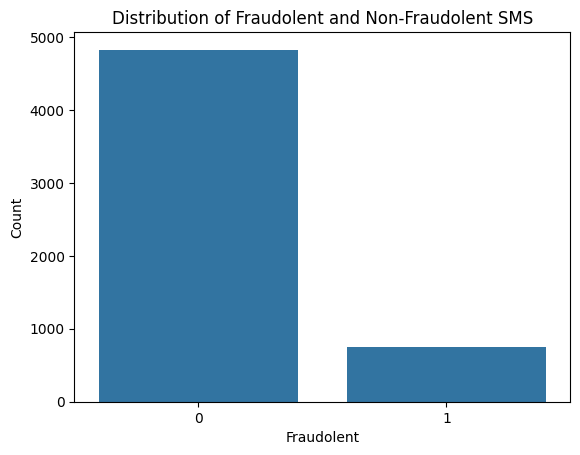

In [4]:
print("Summary Statistics:")
print(df.describe())

sns.countplot(data=df, x="Fraudolent")
plt.title('Distribution of Fraudolent and Non-Fraudolent SMS')
plt.xlabel('Fraudolent')
plt.ylabel('Count')
plt.show()


<h3 id="section4">Data Preprocessing</h3>

as we have identified earlier, there are no missing values to impute

In [5]:
# splitting the dataframe into training set and test set
# X = df["SMS test"]
# y = df["Fraudolent"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=
#                                                     0.25, random_state=1)
TRAIN_TEST_SPLIT = 3714

#training dataset
train_text=df.SMS_test[:TRAIN_TEST_SPLIT]
train_sentiments=df.Fraudolent[:TRAIN_TEST_SPLIT]

#testing dataset
test_text=df.SMS_test[TRAIN_TEST_SPLIT:]
test_sentiments=df.Fraudolent[TRAIN_TEST_SPLIT:]

print(train_text.shape, train_sentiments.shape)
print(test_text.shape, test_sentiments.shape)
fraudolent = 0
for i in test_sentiments:
  if i == 1:
    fraudolent = fraudolent + 1
print(fraudolent)



(3714,) (3714,)
(1858,) (1858,)
252


In [6]:
# handle missing values


In [7]:
# normalizing text
nltk.download('stopwords')

# tokenizing text
tokenizer=ToktokTokenizer()

# setting english stopwords
stopword_list=nltk.corpus.stopwords.words('english')

# defining function to remove html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# applying denoise-function to text column
df['SMS_test']=df['SMS_test'].apply(strip_html)

# ############### => look into this - either use this block or what comes after really not sure which one is better for normalization
# removing punctuation and special characters from the text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text
# function to normalize text
def normalize_text(text):
    text = strip_html(text)
    tokens = tokenizer.tokenize(clean_text(text))
    tokens = [token for token in tokens if token not in stopword_list]
    return tokens
normalized_data = []
for i in range(len(df)):
    normalized_data.append(normalize_text(df['SMS_test'][i
                                                     ]))
print("Normalization complete!")
print(normalized_data)
#################

# defining function to remove square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# applying denoise-function to text column
df['SMS_test']=df['SMS_test'].apply(remove_between_square_brackets)

# defining function to remove noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

# applying denoise-function to text column
df['SMS_test']=df['SMS_test'].apply(denoise_text)

# defining function to remove special characters
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# applying special-characters-function to text column
df['SMS_test']=df['SMS_test'].apply(remove_special_characters)

# defining function to stemm the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

# applying stemming-function to text column
df['SMS_test']=df['SMS_test'].apply(simple_stemmer)

# setting stopwords to english
stop=set(stopwords.words('english'))
print(stop)

# defining function to remove stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# applying -stopword-function to text column
df['SMS_test']=df['SMS_test'].apply(remove_stopwords)

print(df['SMS_test'])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthurbirnstiel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Normalization complete!
[['Squeeeeeze', 'This', 'christmas', 'hug', 'If', 'u', 'lik', 'frndshp', 'den', 'hug', 'back', 'If', 'u', 'get', 'u', 'r', 'cute', 'u', 'r', 'luvd', 'u', 'r', 'lucky', 'None', 'People', 'hate', 'u'], ['And', 'also', 'Ive', 'sorta', 'blown', 'couple', 'times', 'recently', 'id', 'rather', 'text', 'blue', 'looking', 'weed'], ['Mmm', 'thats', 'better', 'got', 'roast', 'id', 'b', 'better', 'drinks', 'Good', 'indian'], ['Mm', 'kanji', 'dont', 'eat', 'anything', 'heavy', 'ok'], ['So', 'theres', 'ring', 'comes', 'guys', 'costumes', 'Its', 'gift', 'future', 'yowifes', 'Hint', 'hint'], ['Sary', 'need', 'Tim', 'bollox', 'hurt', 'lot', 'tol'], ['Love', 'isnt', 'decision', 'feeling', 'If', 'could', 'decide', 'love', 'life', 'would', 'much', 'simpler', 'less', 'magical'], ['My', 'supervisor', 'find', 'one', 'lor', 'thk', 'students', 'I', 'havent', 'ask', 'yet', 'Tell', 'u', 'aft', 'ask'], ['Dear', 'good', 'morning'], ['Im', 'chennai', 'velachery'], ['Lol', 'grr', 'mom', 'taki

In [8]:
# normalizing training text
norm_train_text=df.SMS_test[:TRAIN_TEST_SPLIT]
norm_train_text[0]
print(len(norm_train_text))

# Normalizing testing text
norm_test_text=df.SMS_test[TRAIN_TEST_SPLIT:]
norm_test_text[4000]
print(len(norm_test_text))
print(norm_test_text)


3714
1858
3714                              carlo say hell mu minut
3715    dun thk ill quit yet hmmm go jazz yogasana oso...
3716    uve bin award 50 play 4 instant cash call 0871...
3717    love ha one law make happi person love way fri...
3718    pleas call amanda regard renew upgrad current ...
                              ...                        
5567    hi wlcome back wonder got eaten lion someth no...
5568                                 sorri ill call later
5569                prabhaim sorydarealyfrm heart im sori
5570                                 nt joke serious told
5571                              say somebodi name tampa
Name: SMS_test, Length: 1858, dtype: object


In [9]:
#Count vectorizer for BoW
cv = CountVectorizer(min_df=0.0,max_df=1.0,binary=True,ngram_range=(1,3))

#transforming the training text
cv_train_text = cv.fit_transform(norm_train_text)

#transforming the testing text
cv_test_text = cv.transform(norm_test_text)

print('BOW_cv_train:', cv_train_text.shape)
print('BOW_cv_test:', cv_test_text.shape)
print(cv_train_text.__class__)

# Normalize the BoW features in the training set
normalized_cv_train_text = normalize(cv_train_text, norm='l1', axis=1)

# Normalize the BoW features in the testing set
normalized_cv_test_text = normalize(cv_test_text, norm='l1', axis=1)

print('Normalized BOW_cv_train:', normalized_cv_train_text.shape)
print('Normalized BOW_cv_test:', normalized_cv_test_text.shape)
print(normalized_cv_train_text.__class__)


BOW_cv_train: (3714, 51158)
BOW_cv_test: (1858, 51158)
<class 'scipy.sparse._csr.csr_matrix'>
Normalized BOW_cv_train: (3714, 51158)
Normalized BOW_cv_test: (1858, 51158)
<class 'scipy.sparse._csr.csr_matrix'>


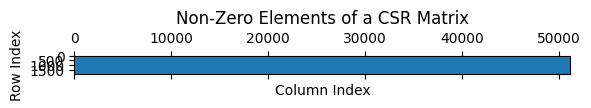

  (0, 40597)	1
  (0, 43152)	1
  (0, 8957)	1
  (0, 21640)	1
  (0, 25432)	1
  (0, 16543)	1
  (0, 11821)	1
  (0, 5035)	1
  (0, 16982)	1
  (0, 10865)	1
  (0, 26933)	1
  (0, 26810)	1
  (0, 30922)	1
  (0, 33169)	1
  (0, 20023)	1
  (0, 40598)	1
  (0, 43177)	1
  (0, 8963)	1
  (0, 21645)	1
  (0, 25433)	1
  (0, 16544)	1
  (0, 11829)	1
  (0, 21641)	1
  (0, 5070)	1
  (0, 17084)	1
  :	:
  (3711, 39945)	1
  (3711, 7688)	1
  (3711, 46580)	1
  (3711, 19321)	1
  (3711, 46581)	1
  (3711, 19322)	1
  (3711, 46582)	1
  (3712, 25436)	1
  (3712, 22928)	1
  (3712, 22933)	1
  (3713, 12655)	1
  (3713, 10355)	1
  (3713, 4348)	1
  (3713, 24118)	1
  (3713, 14523)	1
  (3713, 12743)	1
  (3713, 8710)	1
  (3713, 10356)	1
  (3713, 24183)	1
  (3713, 14526)	1
  (3713, 4386)	1
  (3713, 12751)	1
  (3713, 24184)	1
  (3713, 14527)	1
  (3713, 10358)	1


In [10]:
# Visualize the sparse matrix
plt.spy(cv_test_text, markersize=5)
plt.title('Non-Zero Elements of a CSR Matrix')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()
print(cv_train_text)


In [11]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))

#transforming training text
tv_train_text=tv.fit_transform(norm_train_text)

#transforming testing text
tv_test_text=tv.transform(norm_test_text)

print('Tfidf_train:', tv_train_text.shape)
print('Tfidf_test:', tv_test_text.shape)

print(df.head())


Tfidf_train: (3714, 51158)
Tfidf_test: (1858, 51158)
   Fraudolent                                           SMS_test       ID  \
0           0  squeeeeez thi christma hug u lik frndshp den h...  1EWYRBL   
1           0  also ive sorta blown coupl time recent id rath...  ZY4PDK7   
2           0  mmm better got roast id b better drink 2 good ...  KLUX2C6   
3           0                   mm kanji dont eat anyth heavi ok  955HXJ0   
4           0    ring come guy costum gift futur yowif hint hint  00Q6EUC   

  Date and Time  
0    2017-12-02  
1    2018-03-23  
2    2016-10-29  
3    2018-04-12  
4    2016-08-01  


In [12]:
# Visualize the sparse matrix
plt.spy(tv_train_text, markersize=5)
plt.title('Non-Zero Elements of a CSR Matrix')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()
# print(tv_train_text)


NameError: name 'tv_train_text' is not defined

<h3 id="section5">Models</h3>

The objective is to design a mechanism that identifies and flags fraudulent messages automatically by distinguishing them from non-fraudulent messages. Therefore we face a classification problem. Since the training data is already labled according to this distinction we will be training and testing using primarily supervised machine learning algorithms and finally comparing the performace of these with an alternative approach by using an Artificial Neural Network.

In [13]:
# keeping track of all confusion matrices
conf_matrices = {}
best_hyperparameters = {}


<h4>Model 1: Logisitc Regression</h4>

<strong style="color: red;">First, create a validation set from the training set to analyze the behaviour with the default hyperparameters</strong>

In [14]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)


Training with Bag of words

In [15]:
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_text)


Testing with Bag of Words

lr_bow_score : 0.9628632938643703
                precision    recall  f1-score   support

Non-Fraudolent       0.96      1.00      0.98      1606
    Fraudolent       1.00      0.73      0.84       252

      accuracy                           0.96      1858
     macro avg       0.98      0.86      0.91      1858
  weighted avg       0.96      0.96      0.96      1858



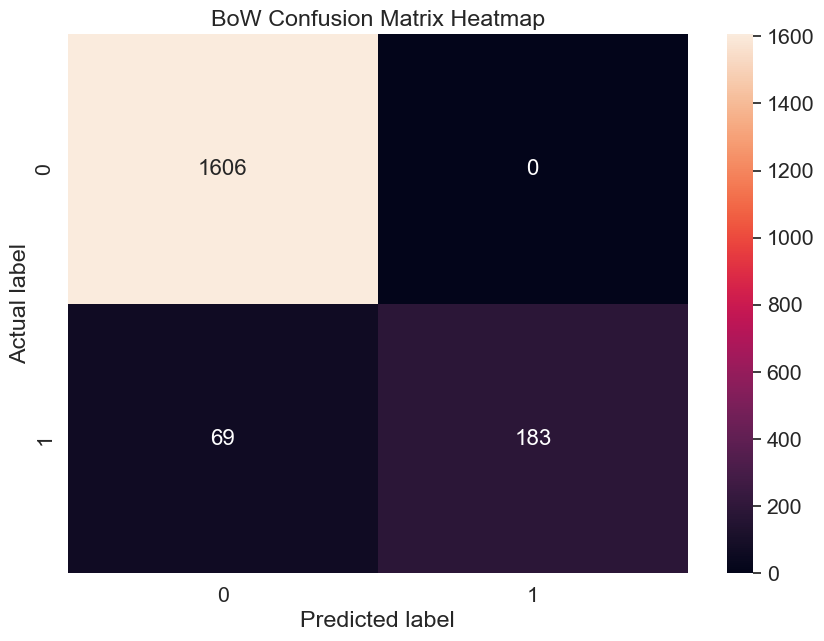

In [16]:
# Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

# Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(lr_bow_report)

# confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[0,1])
conf_matrices["lr_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

<strong style="color: red;">You must describe every hyperparameter tuned (the more, the better)</strong>

In [17]:
# Specify the parameter grid
def k_cross_v(model, param_grid, x_train, y_train, n_splits=5, n_jobs=-1, scoring='f1'):
  # Create a KFold object
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Create the GridSearchCV object
  grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=kf, n_jobs=n_jobs)

  # Fit the model to the data
  grid_search.fit(x_train, y_train)

  # Extracting results
  results = grid_search.cv_results_
  results_df = pd.DataFrame(results).sort_values(by='rank_test_score')
  best_hyperparameters = results_df["params"][0]

  return best_hyperparameters


In [32]:
params_lr = {'penalty': ["l1", "l2", "elasticnet", None], 'max_iter': [400, 500, 600, 700], 'C': [0.5, 1, 1.5]}

lr_hyperparameters = k_cross_v(lr, params_lr, cv_train_text, train_sentiments)

print(lr_hyperparameters)


{'C': 0.5, 'max_iter': 400, 'penalty': 'l1'}


In [33]:
lr = LogisticRegression(penalty=lr_hyperparameters['penalty'], max_iter=lr_hyperparameters['max_iter'], C=lr_hyperparameters['C'])
#Fitting the model for Bag of words
lr_bow = lr.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_text)
# Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

# Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(lr_bow_report)

# confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[0,1])
# best_conf_matrices["lr_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Training with TF-IDF

In [26]:
# Fitting the model for tfidf features
lr_tfidf = lr.fit(tv_train_text,train_sentiments)

# Predicting the model for tfidf features
lr_tfidf_predict = lr.predict(tv_test_text)


Testing with TF-IDF

lr_tfidf_score : 0.8896663078579118
                precision    recall  f1-score   support

Non-Fraudolent       0.89      1.00      0.94      1606
    Fraudolent       0.96      0.19      0.32       252

      accuracy                           0.89      1858
     macro avg       0.92      0.60      0.63      1858
  weighted avg       0.90      0.89      0.86      1858



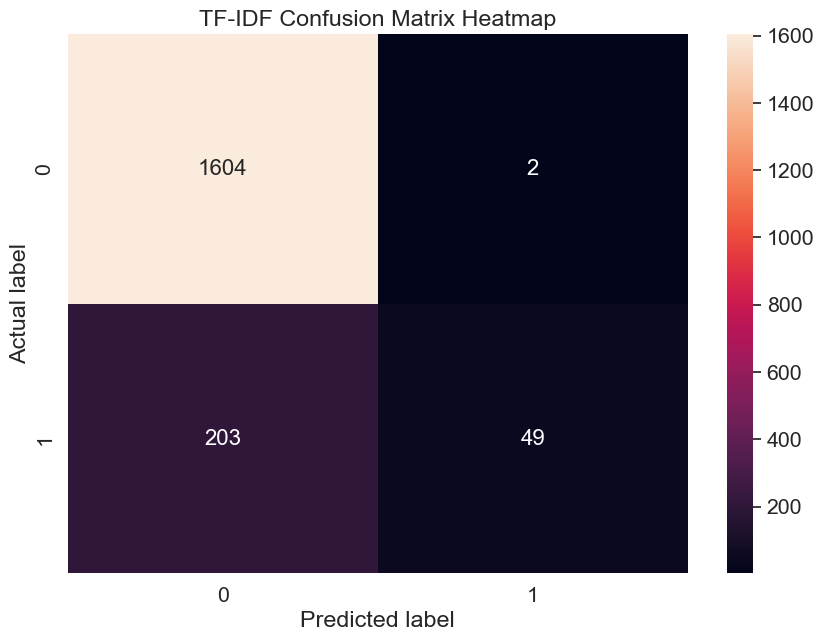

In [27]:
# Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

# Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(lr_tfidf_report)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[0,1])
conf_matrices["lr_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [31]:
# Specify the parameter grid
params_lr = {'penalty': ["l1", "l2", "elasticnet", None], 'max_iter': [400, 500, 600, 700], 'C': [0.5, 1, 1.5]}

lr_hyperparameters = k_cross_v(lr, params_lr, tv_train_text, train_sentiments)

print(lr_hyperparameters)


{'C': 0.5, 'max_iter': 400, 'penalty': 'l1'}


<h4>Model 2: Linear and Kernel SVM</h4>

<h5>Linear SVM</h5>

In [77]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)


Training with Bag of Words

In [78]:
#fitting the svm for bag of words
svm_bow=svm.fit(normalized_cv_train_text,train_sentiments)

#Predicting the model for bag of words
svm_bow_predict=svm.predict(normalized_cv_test_text)


Testing with Bag of Words

svm_bow_score : 0.8681377825618946
                precision    recall  f1-score   support

Non-Fraudolent       0.87      1.00      0.93      1606
    Fraudolent       0.82      0.04      0.07       252

      accuracy                           0.87      1858
     macro avg       0.84      0.52      0.50      1858
  weighted avg       0.86      0.87      0.81      1858



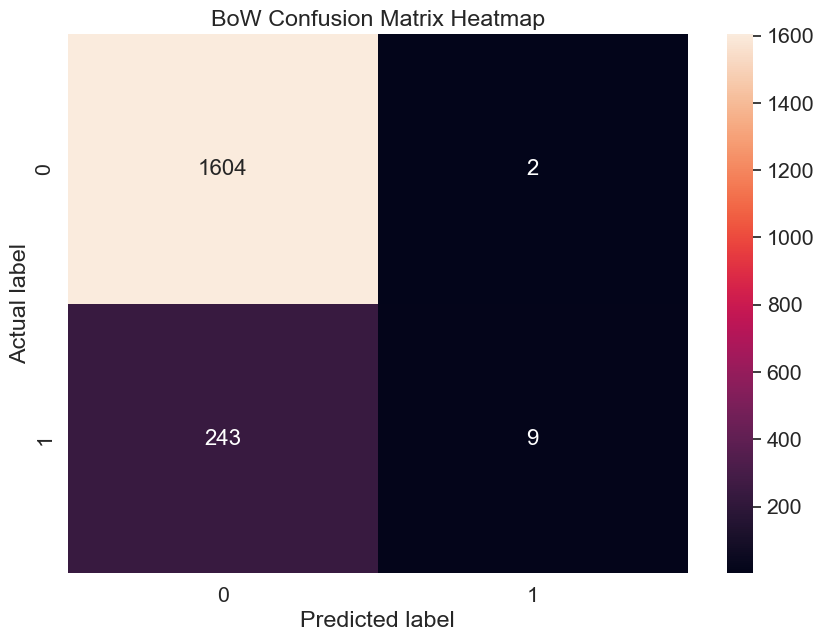

In [79]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)

#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(svm_bow_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[0,1])
conf_matrices["svm_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [131]:
# Specify the parameter grid
param_grid = {'loss': ['log_loss', 'modified_huber', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'max_iter': [400, 500, 600, 700], 'learning_rate': ["constant", "optimal", "adaptive"]}


k_cross_v(svm, param_grid, cv_train_text, train_sentiments)

print(best_hyperparameters)


{'lr_bow': {'C': 0.5, 'max_iter': 400, 'penalty': 'l1'}, 'mnb_bow': {'alpha': 0.5}}


Training with TF-IDF

In [80]:
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_text,train_sentiments)

#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_text)


Testing with TF-IDF

svm_tfidf_score : 0.9773950484391819
                precision    recall  f1-score   support

Non-Fraudolent       0.98      0.99      0.99      1606
    Fraudolent       0.95      0.88      0.91       252

      accuracy                           0.98      1858
     macro avg       0.97      0.94      0.95      1858
  weighted avg       0.98      0.98      0.98      1858



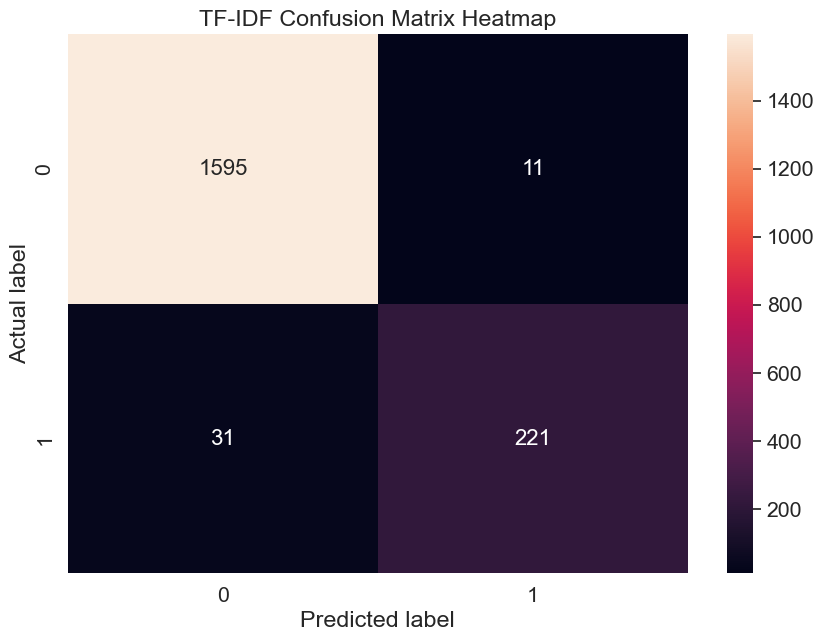

In [81]:
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(svm_tfidf_report)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[0,1])
conf_matrices["svm_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [32]:
# Specify the parameter grid
param_grid = {'loss': ['log_loss', 'modified_huber', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'max_iter': [400, 500, 600, 700], 'learning_rate': ["constant", "optimal", "adaptive"]}

# Create a KFold object with the desired number of folds (e.g., k=5)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, scoring='f1', cv=kf)

# Fit the model to the data
grid_search.fit(tv_train_text, train_sentiments) # takes x_train and y_train

results = grid_search.cv_results_

results_df = pd.DataFrame(results).sort_values(by = 'rank_test_score')
best_hyperparameters["svm_tfidf"] = results_df["params"][0]

results_df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_iter,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
39,0.007474,0.003267,0.000719,0.001068,optimal,perceptron,700,"{'learning_rate': 'optimal', 'loss': 'perceptr...",0.978495,0.978495,...,0.97043,0.956873,0.978437,0.97035,0.967655,0.973046,0.975741,0.972533,0.006367,1
36,0.008942,0.001790,0.001253,0.001588,optimal,perceptron,400,"{'learning_rate': 'optimal', 'loss': 'perceptr...",0.978495,0.978495,...,0.97043,0.956873,0.978437,0.97035,0.967655,0.973046,0.975741,0.972533,0.006367,1
37,0.008582,0.002419,0.000556,0.000573,optimal,perceptron,500,"{'learning_rate': 'optimal', 'loss': 'perceptr...",0.978495,0.978495,...,0.97043,0.956873,0.978437,0.97035,0.967655,0.973046,0.975741,0.972533,0.006367,1
38,0.006984,0.003488,0.001223,0.002582,optimal,perceptron,600,"{'learning_rate': 'optimal', 'loss': 'perceptr...",0.978495,0.978495,...,0.97043,0.956873,0.978437,0.97035,0.967655,0.973046,0.975741,0.972533,0.006367,1
51,0.017478,0.003305,0.000735,0.001498,optimal,epsilon_insensitive,700,"{'learning_rate': 'optimal', 'loss': 'epsilon_...",0.975806,0.978495,...,0.97043,0.951482,0.981132,0.96496,0.959569,0.964960,0.964960,0.968760,0.008810,5


<h5>Kernel SVM</h5>

In [82]:
ksvm = SVC(kernel = 'poly', random_state = 0)


training with Bag of Words

In [83]:
#fitting the ksvm for bow features
ksvm_bow = ksvm.fit(cv_train_text, train_sentiments)

# Predicting the Test set results
ksvm_bow_predict = ksvm.predict(cv_test_text)


Testing with Bag of Words

svm_bow_score : 0.9133476856835306
                precision    recall  f1-score   support

Non-Fraudolent       0.91      1.00      0.95      1606
    Fraudolent       1.00      0.36      0.53       252

      accuracy                           0.91      1858
     macro avg       0.95      0.68      0.74      1858
  weighted avg       0.92      0.91      0.90      1858



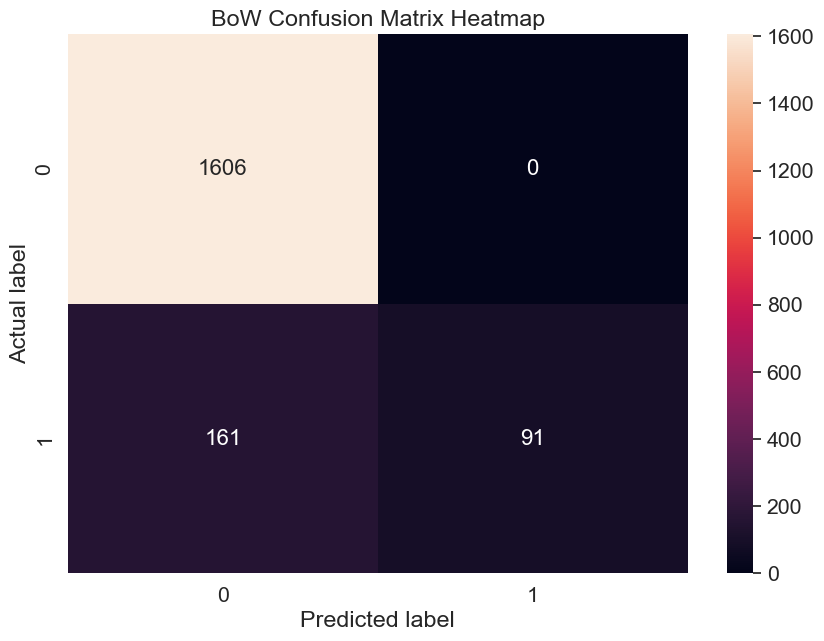

In [84]:
#Accuracy score for bag of words
acc_bow=accuracy_score(test_sentiments,ksvm_bow_predict)
print("svm_bow_score :",acc_bow)

#Classification report for bag of words
bow_report=classification_report(test_sentiments,ksvm_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(bow_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,ksvm_bow_predict,labels=[0,1])
conf_matrices["ksvm_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [85]:
# Specify the parameter grid
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'max_iter': [400, 500, 600, 700], 'gamma': ["scale", "auto"]}

# Create a KFold object with the desired number of folds (e.g., k=5)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(ksvm, param_grid, scoring='f1', cv=kf)

# Fit the model to the data
grid_search.fit(tv_train_text, train_sentiments) # takes x_train and y_train

results = grid_search.cv_results_

results_df = pd.DataFrame(results).sort_values(by = 'rank_test_score')
best_hyperparameters["ksvm_bow"] = results_df["params"][0]

results_df.head()


KeyboardInterrupt: 

training with TF-IDF

In [86]:
ksvm_tfidf = ksvm.fit(tv_train_text, train_sentiments)
# Predicting the Test set results
ksvm_tfidf_predict = ksvm.predict(tv_test_text)


Testing with TF_IDF

ksvm_tfidf_score : 0.9095801937567277
                precision    recall  f1-score   support

Non-Fraudolent       0.91      1.00      0.95      1606
    Fraudolent       1.00      0.33      0.50       252

      accuracy                           0.91      1858
     macro avg       0.95      0.67      0.73      1858
  weighted avg       0.92      0.91      0.89      1858



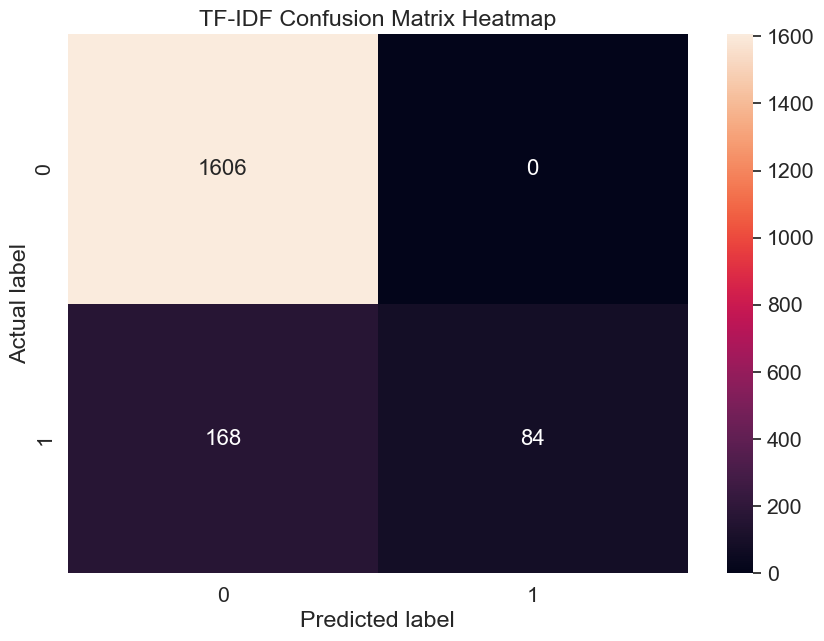

In [121]:
#Accuracy score for bag of words
acc_tfidf=accuracy_score(test_sentiments,ksvm_tfidf_predict)
print("ksvm_tfidf_score :",acc_tfidf)

#Classification report for bag of words
tfidf_report=classification_report(test_sentiments,ksvm_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(tfidf_report)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,ksvm_tfidf_predict,labels=[0,1])
conf_matrices["ksvm_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [44]:
# Specify the parameter grid
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'max_iter': [400, 500, 600, 700], 'gamma': ["scale", "auto"]}

# Create a KFold object with the desired number of folds (e.g., k=5)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(ksvm, param_grid, scoring='f1', cv=kf)

# Fit the model to the data
grid_search.fit(tv_train_text, train_sentiments) # takes x_train and y_train

results = grid_search.cv_results_

results_df = pd.DataFrame(results).sort_values(by = 'rank_test_score')
best_hyperparameters["ksvm_tfidf"] = results_df["params"][0]

results_df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_kernel,param_max_iter,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
28,0.611724,0.131883,0.066556,0.017421,auto,sigmoid,400,"{'gamma': 'auto', 'kernel': 'sigmoid', 'max_it...",0.970430,0.981183,...,0.986559,0.973046,0.989218,0.973046,0.96496,0.978437,0.981132,0.976844,0.007346,1
24,0.704954,0.267008,0.078133,0.024212,auto,rbf,400,"{'gamma': 'auto', 'kernel': 'rbf', 'max_iter':...",0.970430,0.981183,...,0.983871,0.973046,0.986523,0.973046,0.96496,0.975741,0.978437,0.976304,0.006124,2
0,0.500894,0.092704,0.049961,0.006850,scale,linear,400,"{'gamma': 'scale', 'kernel': 'linear', 'max_it...",0.975806,0.981183,...,0.978495,0.962264,0.981132,0.967655,0.96496,0.970350,0.973046,0.973070,0.006281,3
16,0.445540,0.036243,0.044801,0.003370,auto,linear,400,"{'gamma': 'auto', 'kernel': 'linear', 'max_ite...",0.975806,0.981183,...,0.978495,0.962264,0.981132,0.967655,0.96496,0.970350,0.973046,0.973070,0.006281,3
12,0.427819,0.024377,0.045906,0.002915,scale,sigmoid,400,"{'gamma': 'scale', 'kernel': 'sigmoid', 'max_i...",0.975806,0.978495,...,0.978495,0.959569,0.981132,0.967655,0.96496,0.970350,0.973046,0.972800,0.006669,5


<h4>Model 3: Multinomial NB</h4>

In [88]:
#training the model
mnb=MultinomialNB()


Training with Bag of Words

In [89]:
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_text)


mnb_bow_score : 0.9757804090419806
                precision    recall  f1-score   support

Non-Fraudolent       0.98      1.00      0.99      1606
    Fraudolent       0.96      0.85      0.91       252

      accuracy                           0.98      1858
     macro avg       0.97      0.92      0.95      1858
  weighted avg       0.98      0.98      0.98      1858



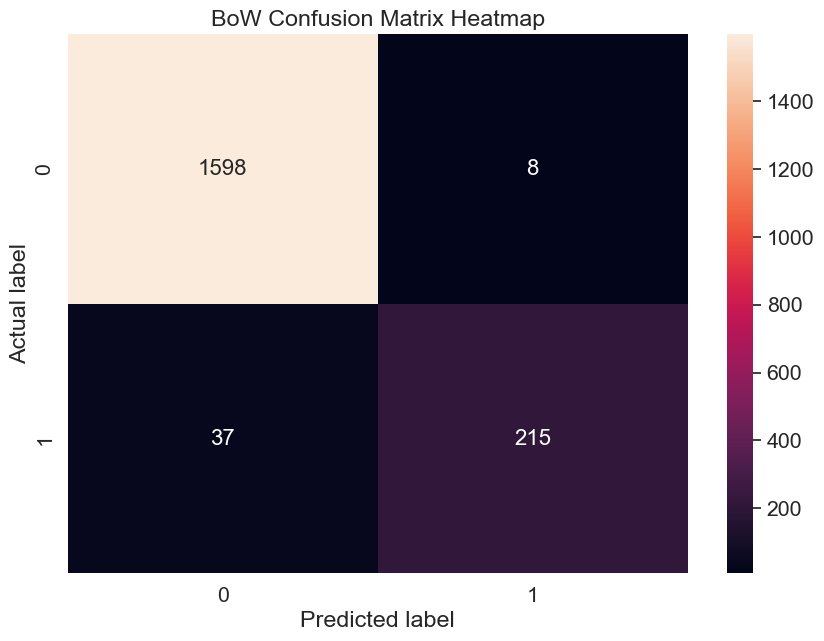

In [90]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(mnb_bow_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[0,1])
conf_matrices["mnb_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [91]:
# Specify the parameter grid
param_grid = {'alpha': [0.5,1,1.5,2]}

# Create a KFold object with the desired number of folds (e.g., k=5)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(mnb, param_grid, scoring='f1', cv=kf)

# Fit the model to the data
grid_search.fit(tv_train_text, train_sentiments) # takes x_train and y_train

results = grid_search.cv_results_

results_df = pd.DataFrame(results).sort_values(by = 'rank_test_score')
best_hyperparameters["mnb_bow"] = results_df["params"][0]

results_df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005073,0.001047,0.003812,0.000744,0.5,{'alpha': 0.5},0.870370,0.896552,0.876712,0.837838,0.813953,0.894118,0.816327,0.833333,0.877551,0.821918,0.853867,0.030820,1
1,0.004991,0.000745,0.004070,0.001740,1,{'alpha': 1},0.688172,0.720000,0.596491,0.676923,0.563380,0.676056,0.585366,0.675676,0.552632,0.634921,0.636962,0.055652,2
2,0.004493,0.000446,0.003072,0.000200,1.5,{'alpha': 1.5},0.512195,0.588235,0.518519,0.464286,0.406250,0.553846,0.410959,0.537313,0.450704,0.407407,0.484971,0.062695,3
3,0.004736,0.000856,0.003677,0.000670,2,{'alpha': 2},0.328767,0.476190,0.260870,0.244898,0.210526,0.379310,0.294118,0.310345,0.307692,0.244898,0.305761,0.073239,4


Training with TF-IDF

In [92]:
# fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_text,train_sentiments)

#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_text)


Testing with TF-IDF

mnb_tfidf_score : 0.9311087190527448
                precision    recall  f1-score   support

Non-Fraudolent       0.93      1.00      0.96      1606
    Fraudolent       1.00      0.49      0.66       252

      accuracy                           0.93      1858
     macro avg       0.96      0.75      0.81      1858
  weighted avg       0.94      0.93      0.92      1858



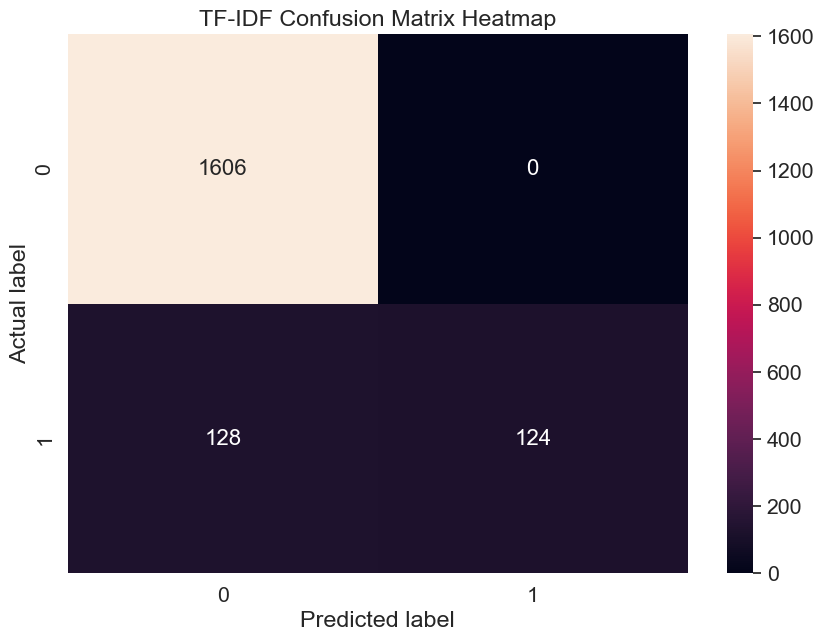

In [93]:
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)


#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(mnb_tfidf_report)


#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[0,1])
conf_matrices["mnb_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [54]:
# Specify the parameter grid
param_grid = {'alpha': [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

# Create a KFold object with the desired number of folds (e.g., k=5)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(mnb, param_grid, scoring='f1', cv=kf)

# Fit the model to the data
grid_search.fit(tv_train_text, train_sentiments) # takes x_train and y_train

results = grid_search.cv_results_

results_df = pd.DataFrame(results).sort_values(by = 'rank_test_score')
best_hyperparameters["mnb_tfidf"] = results_df["params"][0]

results_df.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007865,0.002328,0.002448,0.001650,0.2,{'alpha': 0.2},0.978495,0.986559,0.983871,0.970430,0.978437,0.978437,0.989218,0.983827,0.973046,0.981132,0.980345,0.005521,1
1,0.005671,0.003451,0.001525,0.001957,0.3,{'alpha': 0.3},0.981183,0.986559,0.981183,0.975806,0.975741,0.986523,0.981132,0.975741,0.981132,0.973046,0.979805,0.004391,2
2,0.005705,0.003537,0.002228,0.002025,0.4,{'alpha': 0.4},0.975806,0.986559,0.981183,0.981183,0.967655,0.981132,0.967655,0.967655,0.978437,0.967655,0.975492,0.006881,3
3,0.003657,0.002695,0.003331,0.004006,0.5,{'alpha': 0.5},0.962366,0.975806,0.975806,0.967742,0.956873,0.975741,0.951482,0.962264,0.967655,0.964960,0.966070,0.007844,4
4,0.007716,0.003240,0.000264,0.000538,0.6,{'alpha': 0.6},0.959677,0.965054,0.967742,0.962366,0.948787,0.970350,0.948787,0.956873,0.951482,0.959569,0.959069,0.007236,5


<h4>Model 4</h4>

Defining the Aritifical Neural Network

In [116]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 51158))

# Adding the second hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# # Adding the third hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# # Adding the fourth hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


Training with Bag of Words

In [112]:
# Fitting the ANN to the Training set
dense_cv_train_text = normalized_cv_train_text.todense()
print(type(dense_cv_train_text))
classifier.fit(dense_cv_train_text, train_sentiments, batch_size = 20, epochs = 5)


<class 'numpy.matrix'>
Epoch 1/5
186/186 [==============================] - 5s 18ms/step - loss: 0.5230 - accuracy: 0.8667
Epoch 2/5
186/186 [==============================] - 3s 18ms/step - loss: 0.3355 - accuracy: 0.8667
Epoch 3/5
186/186 [==============================] - 3s 18ms/step - loss: 0.1787 - accuracy: 0.8667
Epoch 4/5
186/186 [==============================] - 3s 18ms/step - loss: 0.1015 - accuracy: 0.9502
Epoch 5/5
186/186 [==============================] - 3s 18ms/step - loss: 0.0893 - accuracy: 0.9970


Testing with Bag of Words

In [113]:
# Predicting the Test set results
dense_cv_test_text = normalized_cv_test_text.todense()
y_pred = classifier.predict(dense_cv_test_text)
y_pred = (y_pred > 0.5)


59/59 [==============================] - 0s 4ms/step


ann_bow_score : 0.9736275565123789
                precision    recall  f1-score   support

Non-Fraudolent       0.98      0.99      0.98      1606
    Fraudolent       0.96      0.85      0.90       252

      accuracy                           0.97      1858
     macro avg       0.97      0.92      0.94      1858
  weighted avg       0.97      0.97      0.97      1858



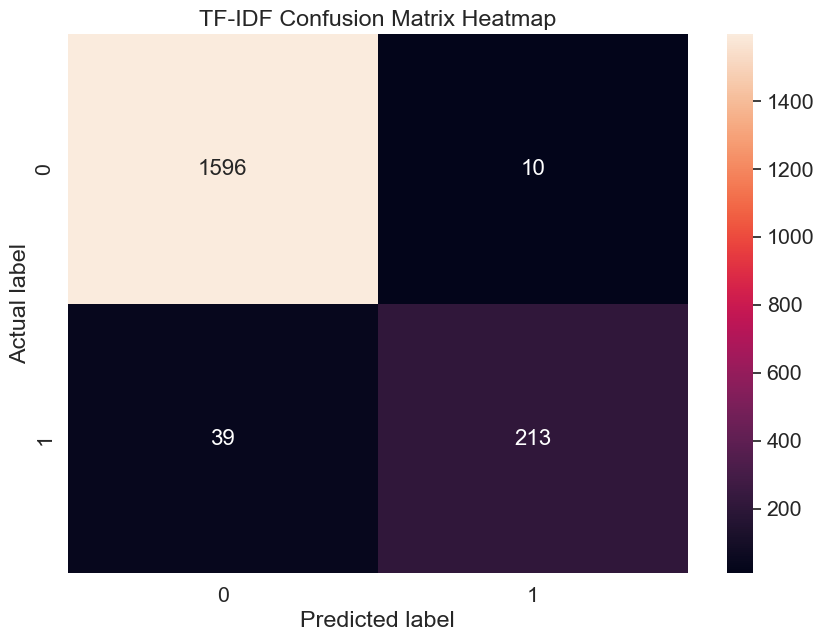

In [115]:
#Accuracy score for bag of words
acc_bow=accuracy_score(test_sentiments, y_pred)
print("ann_bow_score :",acc_bow)

#Classification report for bag of words
bow_report=classification_report(test_sentiments, y_pred,target_names=["Non-Fraudolent","Fraudolent"])
print(bow_report)
# Making the Confusion Matrix
cm_bow = confusion_matrix(test_sentiments, y_pred)
conf_matrices["ann_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


Training with TF-IDF

In [117]:
# Fitting the ANN to the Training set
print(type(tv_train_text))
dense_tv_train_text = tv_train_text.todense()
print(type(dense_tv_train_text))
classifier.fit(dense_tv_train_text, train_sentiments, batch_size = 20, epochs = 5)


<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.matrix'>
Epoch 1/5
186/186 [==============================] - 5s 20ms/step - loss: 0.5561 - accuracy: 0.8621
Epoch 2/5
186/186 [==============================] - 3s 18ms/step - loss: 0.2100 - accuracy: 0.8667
Epoch 3/5
186/186 [==============================] - 4s 19ms/step - loss: 0.1125 - accuracy: 0.8667
Epoch 4/5
186/186 [==============================] - 3s 18ms/step - loss: 0.0940 - accuracy: 0.9645
Epoch 5/5
186/186 [==============================] - 3s 17ms/step - loss: 0.0868 - accuracy: 0.9987


Testing with TF-IDF

In [118]:
# Predicting the Test set results
dense_tv_test_text = tv_test_text.todense()
y_pred = classifier.predict(dense_tv_test_text)
y_pred = (y_pred > 0.5)


59/59 [==============================] - 0s 6ms/step


ann_bow_score : 0.9671689989235738
                precision    recall  f1-score   support

Non-Fraudolent       0.97      1.00      0.98      1606
    Fraudolent       0.98      0.77      0.86       252

      accuracy                           0.97      1858
     macro avg       0.97      0.88      0.92      1858
  weighted avg       0.97      0.97      0.97      1858



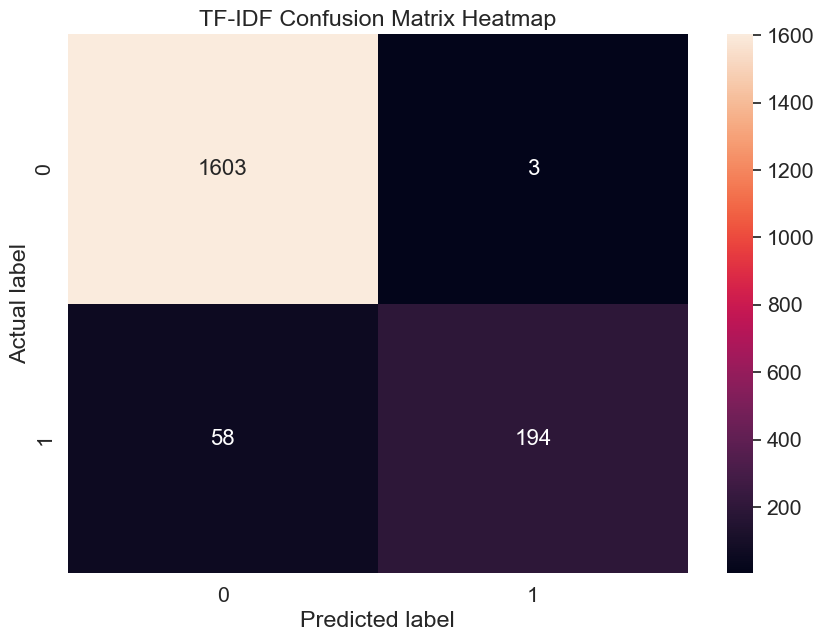

In [119]:
#Accuracy score for bag of words
acc_tfidf=accuracy_score(test_sentiments, y_pred)
print("ann_bow_score :",acc_tfidf)

#Classification report for bag of words
tfidf_report=classification_report(test_sentiments, y_pred,target_names=["Non-Fraudolent","Fraudolent"])
print(tfidf_report)

# Making the Confusion Matrix
cm_tfidf = confusion_matrix(test_sentiments, y_pred)
conf_matrices["ann_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


<h4>Word Cloud</h4>

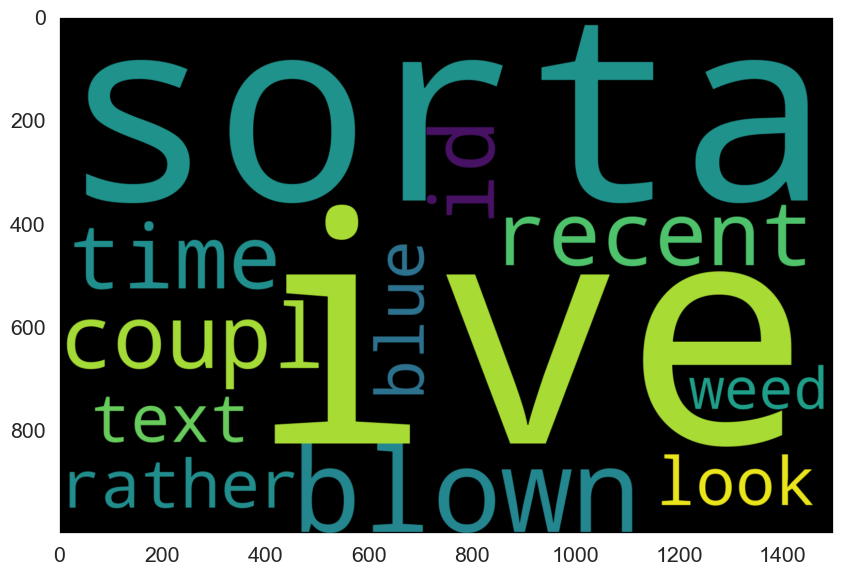

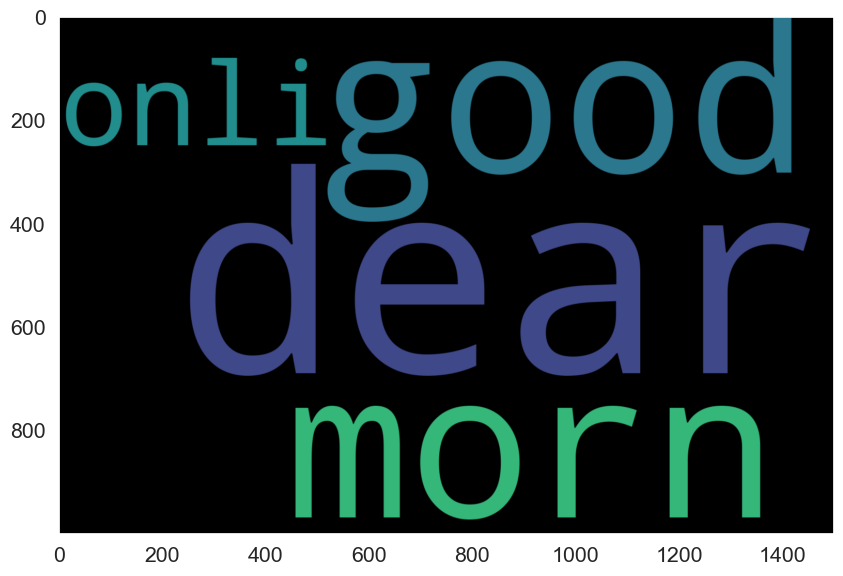

In [106]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_text[1]
WC=WordCloud(width=1500,height=1000,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.grid(False)
plt.show()

#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_text[8]
WC=WordCloud(width=1500,height=1000,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.grid(False)
plt.show()


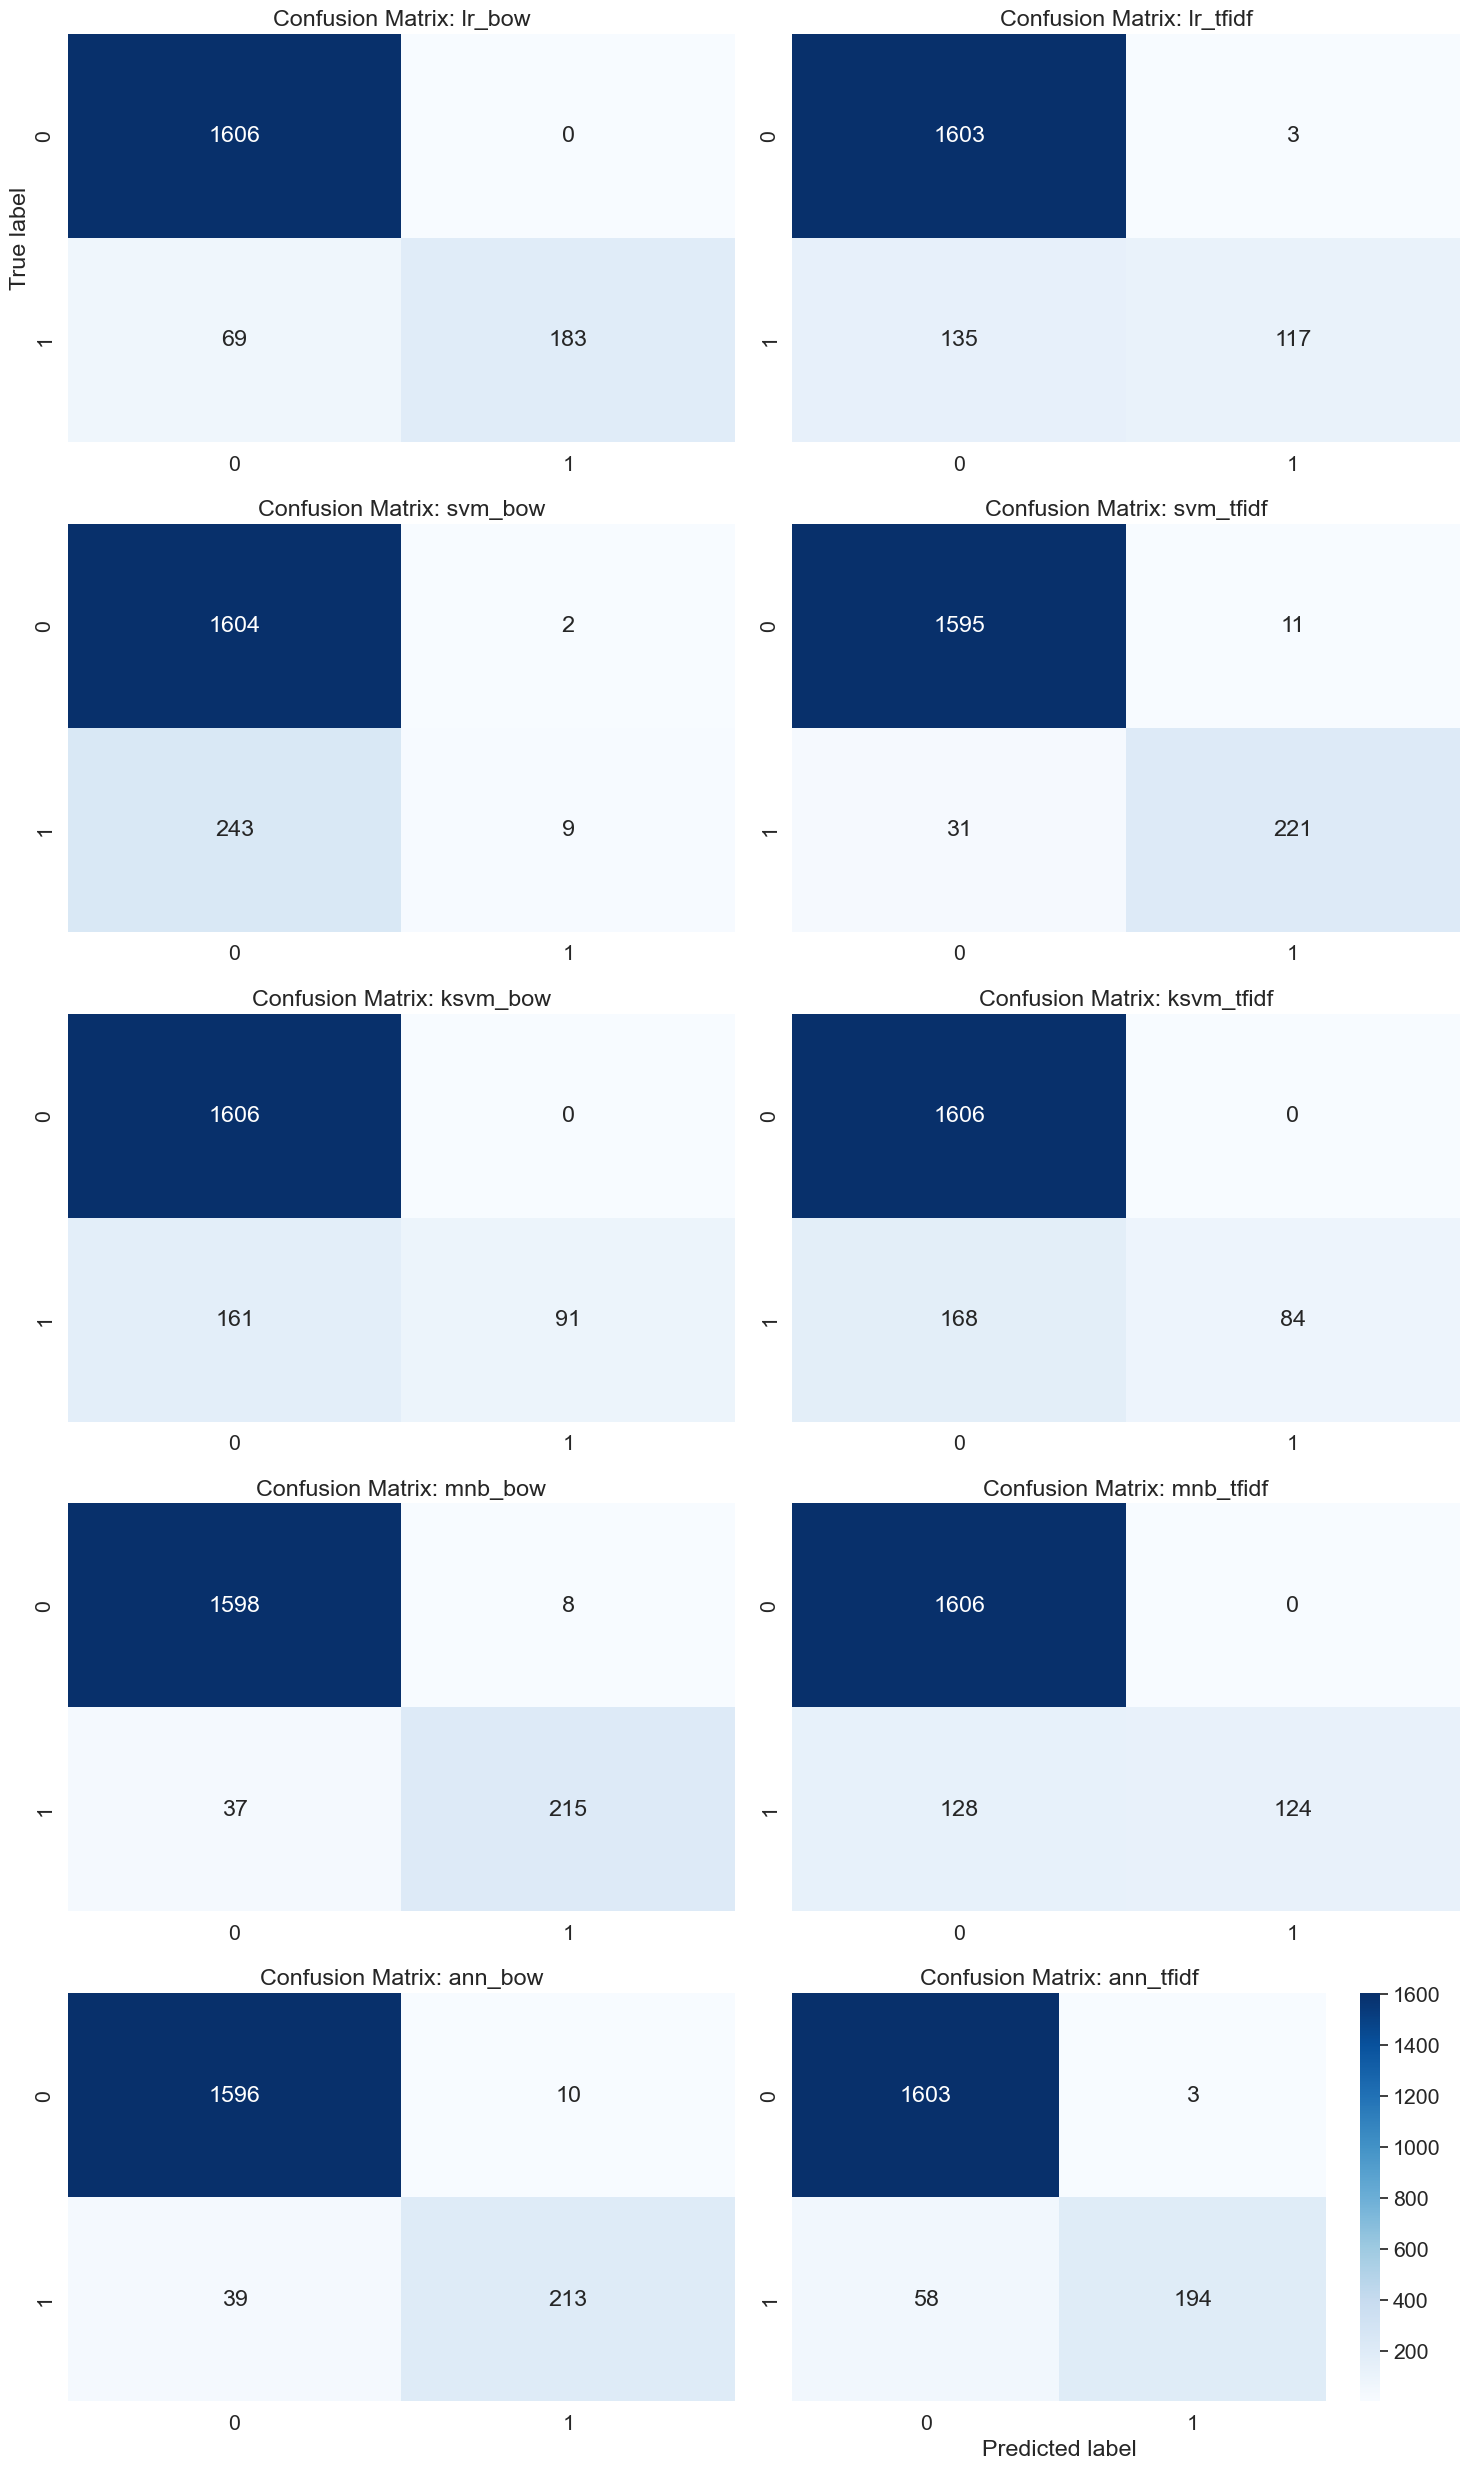

In [122]:
def plot_confusion_matrix(ax, conf_matrix, classifier_name, position):
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=(position == 'last'))
    ax.set_title(f'Confusion Matrix: {classifier_name}')
    if position in ['first', 'middle']:
        ax.set_xlabel('')  # Remove x-label
    else:
        ax.set_xlabel('Predicted label')
    if position in ['middle', 'last']:
        ax.set_ylabel('')  # Remove y-label
    else:
        ax.set_ylabel('True label')

# Determine the number of classifiers (and hence, the number of subplots required)
num_classifiers = len(conf_matrices)

# Create subplots
fig, axes = plt.subplots(num_classifiers // 2, 2, figsize=(15, 5 * (num_classifiers // 2)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
positions = ['first'] + ['middle'] * (num_classifiers - 2) + ['last']
for ax, (classifier_name, conf_matrix), position in zip(axes, conf_matrices.items(), positions):
    plot_confusion_matrix(ax, conf_matrix, classifier_name, position)

plt.tight_layout()
plt.show()


<h3 id="section6">Testing</h3>

In [ ]:
# alt run tests in seperate file?
